In [46]:
import wptherml
from matplotlib import pyplot as plt
import numpy as np
import math

from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from PIL import Image



#Exciton Wavelength to Energy Conversion

#insert wavelength in nm here 
wvl = 370

#Constants and conversion factors
hp = 6.626 * 10 ** (-34)
ltspd = 2.998 * 10 ** 8
jtH = 2.294 * 10 ** 17

epsilon = (hp * ltspd / (wvl * 10 ** (-9))) * jtH


args = {  
'exciton_energy': epsilon, 
'number_of_monomers' : 2,
'displacement_between_monomers' : np.array([1, 0, 0]), 
'transition_dipole_moment' : np.array([0, 0, 0.5]) 
}  

sf = wptherml.SpectrumFactory()  
test = sf.spectrum_factory('Frenkel', args)
test.build_exciton_hamiltonian()

We will call the `compute_exciton_wavefunction_site_basis()`, which 
will evaluate the wavefunctions localized along the sites of each monomer as follows:

$$ \phi_n(x) = a \: {\rm exp}\left( -\frac{(x-x_n)^2}{2c^2} \right) $$

where $x_n$ is x-coordinate for the center of mass of exciton on site $n$.

In [47]:
test.compute_exciton_wavefunction_site_basis()

Calling this method also create a grid of $x$ values spanning values between `.x_min` and `.x_max`, which are derived
from the `.number_of_monomers` and `.displacement_between_monomers` attributes.

In [48]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
plt.close()

### parameters for plot
ax.set_xlim((test.x_min, test.x_max))
ax.set_ylim((0, 4))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
plt.show()
#plt.savefig("exciton_plot.png")

We can plot a few of these exciton wavefunctions as follows:

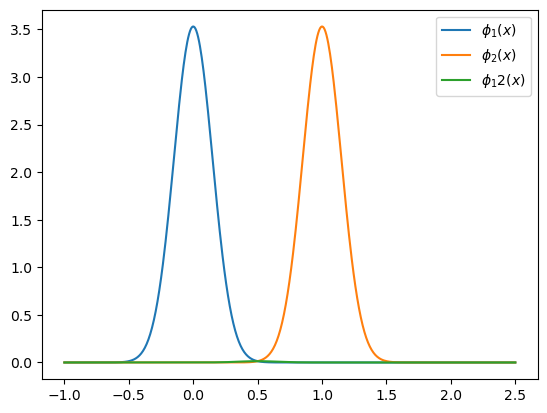

In [49]:
plt.plot(test.x, test.phi[:,0] ** 2, label="$\phi_1(x)$")
plt.plot(test.x, test.phi[:,1] ** 2, label="$\phi_2(x)$")
plt.plot(test.x, test.phi[:,0] * test.phi[:,1], label="$\phi_12(x)$")
#plt.plot(test.x, test.phi[:,3], label="$\phi_4(x)$")
plt.legend()
plt.show()

## RK method for Wavefunction $ \phi $

In [68]:
N_time = 100
t = np.zeros(N_time)


# animation function. This is called sequentially  
def animate(i):
    t = i / 10
    E = test._rk_exciton(0.5) #<== run your rk4 method here!
    
    y = np.zeros(len(test.phi[:,0]), dtype=complex)
    
    for j in range(test.number_of_monomers):
        for k in range(test.number_of_monomers):
            y[:] += test.c_vector[j] * test.phi[:,j] * test.c_vector[k] * test.phi[:,k]
            
    line.set_data(test.x, y)
    return (line,)
  

anim = animation.FuncAnimation(fig, animate, init_func=init,
                             frames=N_time, interval=100, blit=True)

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

/Users/ptolley1/miniconda3/envs/wptherml/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


## Mean Squared Displacement (MSD)

The trapezoid rule will be used to calculate the MSD:

$$ \langle{\Psi}|x^2|\Psi\rangle \equiv \int{\Psi^* x^2 \Psi} dx = \int{\lbrack c_j \phi_j^* \rbrack x^2 \lbrack c_k \phi_k\rbrack dx}$$



TypeError: float() argument must be a string or a real number, not 'Line2D'

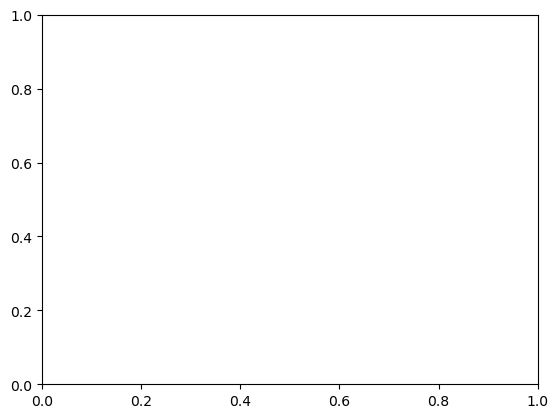

In [78]:
N_time = 100
t = np.zeros(N_time)


# animation function. This is called sequentially  
def MSD(i):
    t = i / 10
    E = test._rk_exciton(0.5) #<== run your rk4 method here!
    
    y = np.zeros(len(test.phi[:,0]), dtype=complex)
    prod = 0
    for i in range(test.number_of_monomers):
        prod += np.conj(test.c_vector[i] * test.phi[:,i]) * test.x ** 2 * test.c_vector[i] * test.phi[:,i]
        msd = np.trapz(prod, test.x)
            
    line.set_data(test.x, y)
    return (line,)
plt.plot(MSD(i))



In [ ]:
N_time = 500
prod = 0
msd = 0

for i in range(test.number_of_monomers):
        for k in range(N_time):
            dt = k * 0.5
            prod += np.conj(test._rk_exciton(dt) * test.phi[:,i]) * test.x ** 2 * test._rk_exciton(dt) * test.phi[:,i]
            msd = np.trapz(prod, test.x)
print(f'the mean standard displacement is {msd} a.u.')

#plt.plot(range(N_time), msd)
#plt.show

The following animates the dynamics of a exciton wavefunction given for the chain of monomers that takes 
the form

\begin{equation}\tag{1}
P(x,t) = D_{11} \phi^2_1(x) + D_{12}\phi_1(x) \phi_2(x) + D_{21}\phi_2(x) \phi_1(x)  + D_{22}\phi^2_2(x),  
\end{equation}

where the elements of ${\bf D}$ are updated using `_rk_exciton_density_matrix(dt)`.  

This is equvalent to defining $P(x,t) = \Psi^*(x,t) \Psi(x,t)$ where 

\begin{align}\tag{2}
\Psi(x,t) &= c_1 \phi_1(x) + c_2 \phi_2(x) \\
\Psi^*(x,t) &= c^*_1 \phi_1(x) + c^*_2 \phi_2(x) \\
P(x,t) &= c^*_1 c_1 \phi_1^2(x) + c^*_1 c_2 \phi_1(x) \phi_2(x)  + c^*_2 c_1 \phi_2(x) \phi_1(x) + c^*_2 c_2 \phi_2^2(x).
\end{align}

Note that because $c^*_i c_j = c_j c^*_i = D_{ji}$ and $\phi_i(x) \phi_j(x) = \phi_j(x) \phi_i(x)$,
we can see that the definition of $P(x,t)$ in Eq. (1) is equivalent to $P(x,t)$ in Eq. (2).

In [ ]:
N_time = 500
t = np.zeros(N_time)


# animation function. This is called sequentially  
def animate(i):
    t = i / 10
    # _rk_exciton_density_matrix() does not return anything so you don't need an "E = " on the l.h.s.
    test._rk_exciton_density_matrix(0.5) #<== run your rk4 method here! use smallish timestep... ~ 0.01

    
    # trace of density matrix should be 1... if this assert statement fails, probably
    # means you need a smaller timestep for the Runge-Kutta integrator
    tr_d = np.trace(test.density_matrix)
    assert np.isclose(tr_d, 1.0)
    
    # initialize p to be an array of complex zeros
    # note the imaginary part should go to zero after summing up all
    # terms below but individual terms will be complex
    p = np.zeros(len(test.phi[:,0]), dtype=complex)
    
    for j in range(test.number_of_monomers):
        for k in range(test.number_of_monomers):
            p[:] += test.density_matrix[j, k] * test.phi[:,j] * test.phi[:,k]
    
    line.set_data(test.x, p)
    return (line,)
  

anim = animation.FuncAnimation(fig, animate, init_func=init,
                             frames=N_time, interval=100, blit=True)

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim
#anim.save('exciton_1.gif', dpi=500)#, save_all="true", loops=0)


In [ ]:
plt.rcParams['animation.writer'] = 'ffmpeg'
plt.rcParams['animation.ffmpeg_path'] = '/HOME/Code'
time_points = np.linspace(0, 10, 100)
initial_magnitude = 0.5

variables = [0.3, 0.6, 0.8, 0.2]

fig, axs = plt.subplots(2, 2, figsize = (8, 8))

circles = []

for i, ax in enumerate(axs.flat):
    circle = plt.Circle((0.5, 0.5), 0.4, color = 'blue')
    ax.add_artist(circle)
    ax.set_aspect('equal')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.axis('off')
    circles.append(circle)
    
def update(frame):
    magnitude = initial_magnitude + frame * 0.1
    
    for circle in circles:
        color = plt.cm.cool(magnitude)
        circle.set_color(color)
    
animation = FuncAnimation(fig, update, frames = len(time_points), interval = 200)

html_animation = animation.to_html5_video()
HTML(html_animation)